In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [2]:
store = pd.HDFStore('data/optparam.h5')
opt = store['opt']
store.close()

In [3]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [4]:
import concurrent

In [5]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

Import the model

In [6]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [7]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [8]:
test_data_dir = os.path.join(os.getcwd(), '../../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [9]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [10]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [11]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [12]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [13]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [14]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [15]:
    testconfig = _ConfigDistro(
        distro_array=np.array([        [5, 25],
        [0.04, 1],
        [0.161, 0.569],
        [0.55, 2.55],
        [0, 7],
        [2 / 3.71, 8 / 3.71]]),
        setvalues={
            "qbmb": 0,
            "qo3": 0.5,
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
        },
    )

In [16]:
testconfig.ordering

['rlamdo',
 'akapa',
 'cpi',
 'W',
 'beto',
 'lambda',
 'mixed',
 'qdirso2',
 'qindso2',
 'qbc',
 'qoc',
 'beta_f',
 'mixed_carbon',
 'qh2o_ch4']

In [17]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

In [18]:
len(opt)

1000

In [19]:
distrorun1 = DistributionRun(testconfig, numvalues=len(opt))
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[ 5.          0.04        0.161       0.55        0.          0.53908356
 25.         -0.55       -1.5         0.1        -0.1         0.11
 25.          0.08      ]
[ 2.50000000e+01  1.00000000e+00  5.69000000e-01  2.55000000e+00
  7.00000000e+00  2.15633423e+00  1.25000000e+02 -2.00000000e-01
 -5.00000000e-01  2.00000000e-01 -6.00000000e-02  4.65000000e-01
  1.25000000e+02  1.00000000e-01]


In [20]:
def get_results(cfg):
    try:
        cscm_dir._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
        res=cscm_dir.results

    except:
        res=None
    return [cfg,res]

In [21]:
def run_parallel(cfgs,nworkers=4):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            pres=list(tqdm(exe.map(get_results, cfgs)))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [22]:
distrorun1.cfgs[0].keys()

dict_keys(['pamset_udm', 'pamset_emiconc', 'Index'])

In [23]:
for j,c in enumerate(distrorun1.cfgs):
    for typ in ['pamset_udm','pamset_emiconc']:
        pkys=list(c[typ].keys())
        ins=list(set(opt.iloc[j].keys()).intersection(pkys))
        for i in ins:   
            c[typ][i]=opt.iloc[j][i]


In [24]:
cscm_dir._run({"results_as_dict": True},pamset_udm=distrorun1.cfgs[0]['pamset_udm'],pamset_emiconc=distrorun1.cfgs[0]['pamset_emiconc'])

In [26]:
results=run_parallel(distrorun1.cfgs,nworkers=100)

1000it [00:30, 32.48it/s]


In [28]:
flds=['dT_glob','OHC700','concentrations-CO2','RIB_glob']

In [29]:
isgd=np.where([r!=None for r in results])[0].astype(int)

In [30]:
fresults = [results[i] for i in isgd]
fcfgs=[distrorun1.cfgs[i] for i in isgd]

In [31]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [32]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    return ensdf

In [33]:
df=make_ensdf(fresults,flds)

In [34]:
issane=np.where(df.max()<1e8)[0]

In [35]:
df

0         1         2         3         4         5    \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751  0.000044  0.000054  0.000046  0.000054  0.000049  0.000035   
         1752  0.000225  0.000241  0.000230  0.000257  0.000242  0.000185   
         1753  0.000543  0.000534  0.000546  0.000596  0.000572  0.000460   
         1754  0.000949  0.000889  0.000937  0.001017  0.000990  0.000818   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  0.967170  0.885920  0.834353  0.927103  1.029416  0.689972   
         2097  0.954453  0.874612  0.823930  0.915319  1.015235  0.678296   
         2098  0.941806  0.863353  0.813539  0.903590  1.001126  0.666736   
         2099  0.929202  0.852118  0.803156  0.891892  0.987062  0.655262   
         2100  0.916627  0.840896  0.792771  0.880211  0.973029  0.643857   

                    6         7         8         9    ...       990  \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
         1751  0.000062  0.000070  0.000100  0.000080  ...  0.000068   
         1752  0.000274  0.000327  0.000439  0.000355  ...  0.000322   
         1753  0.000612  0.000732  0.000932  0.000769  ...  0.000719   
         1754  0.001026  0.001200  0.001470  0.001242  ...  0.001178   
...                 ...       ...       ...       ...  ...       ...   
RIB_glob 2096  0.991110  0.987524  1.433837  1.327864  ...  0.930964   
         2097  0.978118  0.976288  1.421331  1.314710  ...  0.920245   
         2098  0.965196  0.965079  1.408802  1.301558  ...  0.909543   
         2099  0.952318  0.953875  1.396227  1.288385  ...  0.898835   
         2100  0.939470  0.942662  1.383596  1.275179  ...  0.888112   

                    991       992       993       994       995       996  \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751  0.000039  0.000041  0.000042  0.000048  0.000037  0.000046   
         1752  0.000198  0.000214  0.000211  0.000249  0.000186  0.000229   
         1753  0.000474  0.000521  0.000509  0.000599  0.000447  0.000542   
         1754  0.000827  0.000915  0.000892  0.001033  0.000784  0.000940   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  1.023792  0.838896  0.869951  1.102069  0.911071  0.922758   
         2097  1.010778  0.827938  0.857797  1.089835  0.898578  0.910462   
         2098  0.997826  0.817060  0.845727  1.077647  0.886142  0.898215   
         2099  0.984912  0.806233  0.833712  1.065479  0.873738  0.885992   
         2100  0.972019  0.795441  0.821737  1.053316  0.861351  0.873780   

                    997       998       999  
dT_glob  1750  0.000000  0.000000  0.000000  
         1751  0.000039  0.000047  0.000056  
         1752  0.000198  0.000231  0.000246  
         1753  0.000477  0.000548  0.000538  
         1754  0.000835  0.000951  0.000889  
...                 ...       ...       ...  
RIB_glob 2096  0.919217  1.024399  0.974785  
         2097  0.906759  1.010804  0.962287  
         2098  0.894381  0.997283  0.949820  
         2099  0.882055  0.983809  0.937362  
         2100  0.869767  0.970366  0.924900  

[1404 rows x 1000 columns]

In [36]:
df1 = df.iloc[:,issane]
fcfgs1=[fcfgs[i] for i in issane]

In [37]:
df1.index.names = ['variable', 'year']
df1.columns.names=['run_id']

In [38]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



(0.0, 5.0)

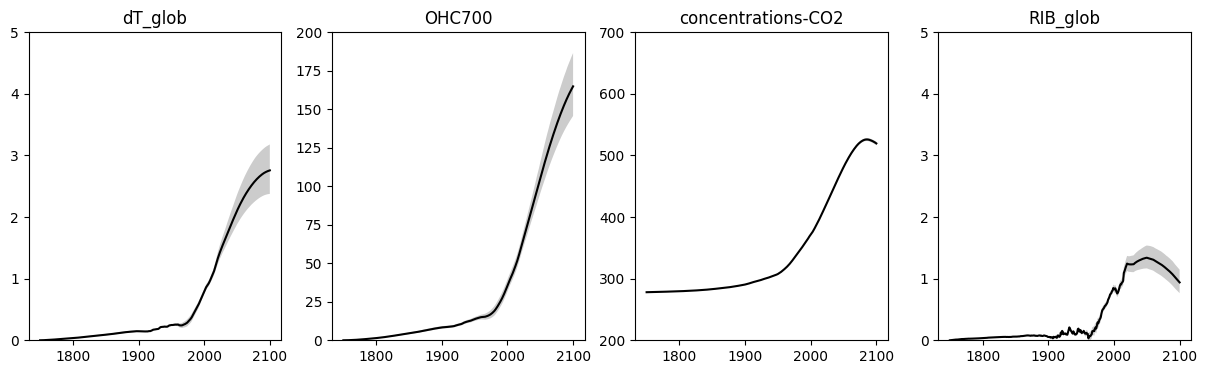

In [39]:
fig, ax = plt.subplots( 1,len(flds) ,figsize=(15, 4))

ax=ax.flatten()
for i,f in enumerate(flds):
    plot_range(df1, f, ax[i])
    ax[i].set_title(f)
ax[0].set_ylim([0,5])
ax[1].set_ylim([0,200])
ax[2].set_ylim([200,700])
ax[3].set_ylim([0,5])

